In [1]:
from __future__ import print_function

import os
from tensorflow.keras import activations
from tensorflow.keras import backend as K
from tensorflow.keras import layers
from tensorflow.keras import utils
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [2]:
workdir = "/Users/joyeuxnoel8/GDrive/Documents/course/CSCI599_DeepLearning/project/datasets/Project"        
os.chdir(workdir)

In [3]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
np.set_printoptions(edgeitems=10)

# Load datasets

In [4]:
def loaddata(path, seed=9527):
    """
    Usage: there should be ./breast/ and ./prostate/ under the path
    """
    
    np.random.seed(seed=seed)
    
    def image2tensor(tumor, cnv):
        train1, train2, train3, testset1, testset2, testset3 = [], [], [], [], [], []
        train = [train1, train2, train3] # 3 channels
        test = [testset1, testset2, testset3]

        rawfnames = !ls ./$tumor/$cnv/*jpg
        rawfnames = np.array(np.sort(rawfnames), dtype=object)
        
        # randomly distribute data to train set and test set in 5:1 ratio
        randomIndices = np.random.permutation(rawfnames.shape[0]//3)
                
        for i, rawf in enumerate(rawfnames):
            im = cv2.imread(rawf, 0)
            channel = i % 3            
            if (randomIndices[i//3]) % 6 == 0:
                test[channel].append(im)
            else:
                train[channel].append(im)
                
        return np.array(train).transpose([1,2,3,0]), np.array(test).transpose([1,2,3,0])
    
    tumors = ["breast", "prostate"]
    cnvs = ["altered", "flat"]
    
    trainset,  testset = {"breast" : {}, "prostate" : {}}, {"breast" : {}, "prostate" : {}}
    data = {"trainset" : trainset , "testset" : testset}
    
    for tumor in tumors:
        for i, cnv in enumerate(cnvs):
            if i == 0:
                trainset[tumor]["pos"], testset[tumor]["pos"] = image2tensor(tumor, cnv)
            elif i == 1:
                trainset[tumor]["neg"], testset[tumor]["neg"] = image2tensor(tumor, cnv)
                
    return data

In [5]:
data = loaddata(workdir)

### Visualize datasets

trainset breast pos (484, 225, 225, 3)
trainset breast neg (455, 225, 225, 3)
trainset prostate pos (323, 225, 225, 3)
trainset prostate neg (285, 225, 225, 3)
testset breast pos (97, 225, 225, 3)
testset breast neg (92, 225, 225, 3)
testset prostate pos (65, 225, 225, 3)
testset prostate neg (58, 225, 225, 3)


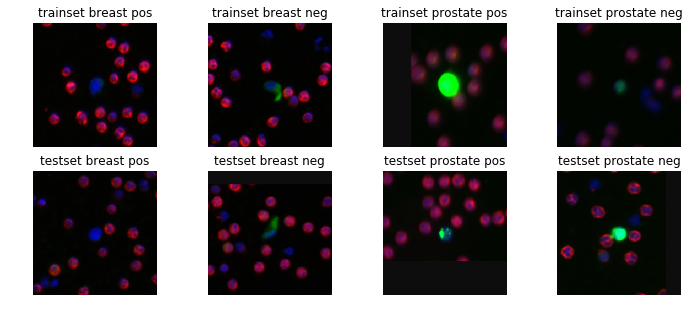

In [107]:
fig, axes = plt.subplots(2,4, figsize=(12,5))
i, j = 0, 0

for subset, d1 in data.items():
    for tumor, d2 in d1.items():
        for cnv, imgs in d2.items():
            print("{} {} {} {}".format(subset, tumor, cnv, imgs.shape))
            axes[i,j%4].imshow(data[subset][tumor][cnv][0])
            axes[i,j%4].set_title("{} {} {}".format(subset, tumor, cnv))
            axes[i,j%4].axis('off')
            j += 1
    i += 1

plt.show()
plt.close()

### Prepare breast cancer datasets

In [78]:
np.random.seed(seed=5408)

# training set
x_pos_all = data["trainset"]["breast"]["pos"] # training set and validation set for cnv+
x_neg_all = data["trainset"]["breast"]["neg"] # training set and validation set for cnv-

x_train = np.concatenate((x_pos_all, x_neg_all))
y_train = utils.to_categorical(np.concatenate((np.ones(x_pos_all.shape[0]), np.zeros(x_neg_all.shape[0]))))

# random shuffling
randind = np.random.permutation(y_train.shape[0])
x_train = x_train[randind].astype('float32')
y_train = y_train[randind]

x_train /= 255


# testing set
x_pos_all = data["testset"]["breast"]["pos"] # training set and validation set for cnv+
x_neg_all = data["testset"]["breast"]["neg"] # training set and validation set for cnv-

x_test = np.concatenate((x_pos_all, x_neg_all)).astype('float32')
x_test /= 255
y_test = utils.to_categorical(np.concatenate((np.ones(x_pos_all.shape[0]), np.zeros(x_neg_all.shape[0]))))


print(x_train.shape, y_train.shape, x_test.shape, y_test.shape)

(939, 225, 225, 3) (939, 2) (189, 225, 225, 3) (189, 2)


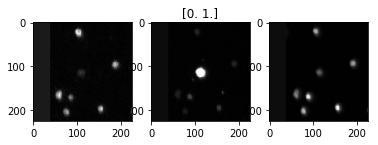

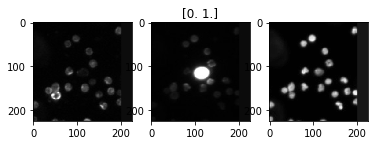

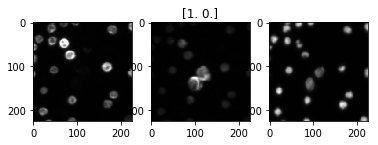

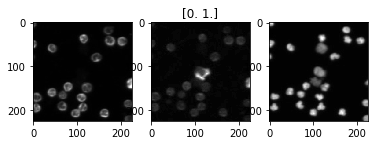

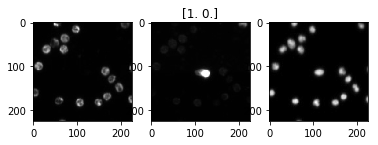

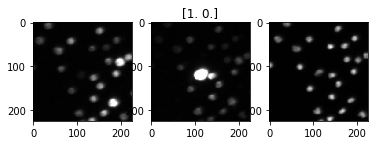

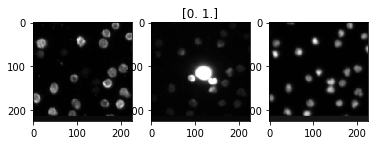

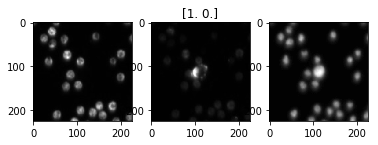

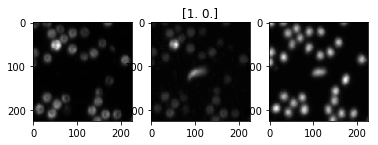

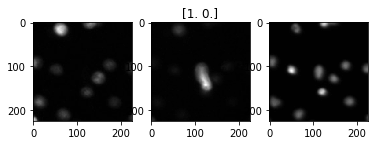

In [68]:
for i in range(10):
    fig, (ax1,ax2,ax3) = plt.subplots(1,3, figsize=(6,2))
    ax1.imshow(x_train[i,:,:,0], cmap='gray')
    ax2.imshow(x_train[i,:,:,1], cmap='gray')
    ax3.imshow(x_train[i,:,:,2], cmap='gray')
    ax2.set_title(y_train[i])
    plt.show()
    plt.close()

# CNN-Capsule Network
Model architecture retrieved from https://github.com/keras-team/keras/blob/master/examples/cifar10_cnn_capsule.py
> This example trains a simple CNN-Capsule Network on the CIFAR10 data set.
> - Without Data Augmentation:
>     It gets to 75% validation accuracy in 10 epochs, 79% after 15 epochs, and overfitting after 20 epochs
> - With Data Augmentation:
>     It gets to 75% validation accuracy in 10 epochs, 79% after 15 epochs, and 83% after 30 epochs. The highest achieved validation accuracy is 83.79% after 50 epochs.
> - This is a fast implementation that takes just 20s/epoch on a GTX 1070 GPU.
> - The paper "Dynamic Routing Between Capsules": https://arxiv.org/abs/1710.09829


In [42]:
def squash(x, axis=-1):
    """The Squashing Function.
    The nonlinear activation function used in Capsule Network
    # Arguments
        x: Input Tensor.
        axis: Integer axis along which the squashing function is to be applied.
    # Returns
        Tensor with scaled value of the input tensor
    """
    s_squared_norm = K.sum(K.square(x), axis, keepdims=True) + K.epsilon()
    scale = K.sqrt(s_squared_norm) / (0.5 + s_squared_norm)
    return scale * x


def margin_loss(y_true, y_pred):
    """Margin loss
    # Arguments
        y_true: tensor of true targets.
        y_pred: tensor of predicted targets.
    # Returns
        Tensor with one scalar loss entry per sample.
    """
    lamb, margin = 0.5, 0.1
    return K.sum(y_true * K.square(K.relu(1 - margin - y_pred)) + lamb * (
        1 - y_true) * K.square(K.relu(y_pred - margin)), axis=-1)


class Capsule(layers.Layer):
    """Capsule Network
    A Capsule Network Layer implementation in Keras
    There are two versions of Capsule Networks.
    One is similar to dense layer (for the fixed-shape input),
    and the other is similar to time distributed dense layer
    (for inputs of varied length).
    The input shape of Capsule must be (batch_size,
                                        input_num_capsule,
                                        input_dim_capsule
                                       )
    and the output shape is (batch_size,
                             num_capsule,
                             dim_capsule
                            )
    The Capsule implementation is from https://github.com/bojone/Capsule/
    # Arguments
        num_capsule: An integer, the number of capsules.
        dim_capsule: An integer, the dimensions of the capsule.
        routings: An integer, the number of routings.
        share_weights: A boolean, sets weight sharing between layers.
        activation: A string, the activation function to be applied.
    """

    def __init__(self,
                 num_capsule,
                 dim_capsule,
                 routings=3,
                 share_weights=True,
                 activation='squash',
                 **kwargs):
        super(Capsule, self).__init__(**kwargs)
        self.num_capsule = num_capsule
        self.dim_capsule = dim_capsule
        self.routings = routings
        self.share_weights = share_weights
        if activation == 'squash':
            self.activation = squash
        else:
            self.activation = activations.get(activation)

    def build(self, input_shape):
        input_dim_capsule = input_shape[-1]
        if self.share_weights:
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(1, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)
        else:
            input_num_capsule = input_shape[-2]
            self.kernel = self.add_weight(
                name='capsule_kernel',
                shape=(input_num_capsule, input_dim_capsule,
                       self.num_capsule * self.dim_capsule),
                initializer='glorot_uniform',
                trainable=True)

    def call(self, inputs, **kwargs):
        """Following the routing algorithm from Hinton's paper,
        but replace b = b + <u,v> with b = <u,v>.
        This change can improve the feature representation of the capsule.
        However, you can replace
            b = K.batch_dot(outputs, hat_inputs, [2, 3])
        with
            b += K.batch_dot(outputs, hat_inputs, [2, 3])
        to get standard routing.
        """

        if self.share_weights:
            hat_inputs = K.conv1d(inputs, self.kernel)
        else:
            hat_inputs = K.local_conv1d(inputs, self.kernel, [1], [1])

        batch_size = K.shape(inputs)[0]
        input_num_capsule = K.shape(inputs)[1]
        hat_inputs = K.reshape(hat_inputs,
                               (batch_size, input_num_capsule,
                                self.num_capsule, self.dim_capsule))
        hat_inputs = K.permute_dimensions(hat_inputs, (0, 2, 1, 3))

        b = K.zeros_like(hat_inputs[:, :, :, 0])
        print(self.routings)
        for i in range(self.routings):
            c = K.softmax(b, 1)
            o = self.activation(K.batch_dot(c, hat_inputs, [2, 2]))
            if i < self.routings - 1:
                b = K.batch_dot(o, hat_inputs, [2, 3])
                if K.backend() == 'theano':
                    o = K.sum(o, axis=1)
        return o

    def compute_output_shape(self, input_shape):
        return None, self.num_capsule, self.dim_capsule

In [43]:
#batch_size = 128
batch_size = 32
num_classes = 2
epochs = 10

In [64]:
# A simple Conv2D model
input_image = layers.Input(shape=(None, None, 3))
x = layers.Conv2D(16, (3, 3), activation='relu')(input_image)
x = layers.Conv2D(16, (3, 3), activation='relu')(x)
x = layers.AveragePooling2D((2, 2))(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)
x = layers.Conv2D(64, (3, 3), activation='relu')(x)

In [65]:
# Now, we reshape it to (batch_size, input_num_capsule, input_dim_capsule)
# then connect a capsule layer.
# The output of final model is the lengths of 10 capsules, which have 16 dimensions.
# The length of the output vector of the capsule expresses the probability of
# existence of the entity, so the problem becomes a 10 two-classification problem.

x = layers.Reshape((-1, 128))(x)
capsule = Capsule(2, 16, 3, True)(x)
output = layers.Lambda(lambda z: K.sqrt(K.sum(K.square(z), 2)))(capsule)
model = Model(inputs=input_image, outputs=output)

3


In [66]:
# Margin loss is used
model.compile(loss=margin_loss, optimizer='adam', metrics=['accuracy'])
model.summary()

Model: "model_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_11 (InputLayer)        [(None, None, None, 3)]   0         
_________________________________________________________________
conv2d_40 (Conv2D)           (None, None, None, 16)    448       
_________________________________________________________________
conv2d_41 (Conv2D)           (None, None, None, 16)    2320      
_________________________________________________________________
average_pooling2d_10 (Averag (None, None, None, 16)    0         
_________________________________________________________________
conv2d_42 (Conv2D)           (None, None, None, 64)    9280      
_________________________________________________________________
conv2d_43 (Conv2D)           (None, None, None, 64)    36928     
_________________________________________________________________
reshape_11 (Reshape)         (None, None, 128)         0  

In [67]:
# Compare the performance with and without data augmentation
data_augmentation = True

if not data_augmentation:
    print('Not using data augmentation.')
    model.fit(
        x_train,
        y_train,
        batch_size=batch_size,
        epochs=epochs,
        validation_split=0.1,
        #validation_data=(x_test, y_test),
        shuffle=True)
else:
    print('Using real-time data augmentation.')
    # This will do preprocessing and real-time data augmentation:
    datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by dataset std
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        zca_epsilon=1e-06,  # epsilon for ZCA whitening
        rotation_range=180,  # randomly rotate images in 0 to 180 degrees
        width_shift_range=0,  # randomly shift images horizontally
        height_shift_range=0,  # randomly shift images vertically
        shear_range=0.,  # set range for random shear
        zoom_range=0.,  # set range for random zoom
        channel_shift_range=0.,  # set range for random channel shifts
        # set mode for filling points outside the input boundaries
        fill_mode='nearest',
        cval=0.,  # value used for fill_mode = "constant"
        horizontal_flip=True,  # randomly flip images
        vertical_flip=True,  # randomly flip images
        # set rescaling factor (applied before any other transformation)
        rescale=None,
        # set function that will be applied on each input
        preprocessing_function=None,
        # image data format, either "channels_first" or "channels_last"
        data_format=None,
        # fraction of images reserved for validation (strictly between 0 and 1)
        validation_split=0.2)

    # Compute quantities required for feature-wise normalization
    # (std, mean, and principal components if ZCA whitening is applied).
    datagen.fit(x_train)

    # Fit the model on the batches generated by datagen.flow().
    model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size, subset="training"),
        validation_data=datagen.flow(x_train, y_train, batch_size=batch_size, subset="validation")
        epochs=epochs,
        use_multiprocessing=True,
        workers=3)

Using real-time data augmentation.
Epoch 1/10
30/30 [==============================] - 100s 3s/step - loss: 0.2616 - accuracy: 0.6571
Epoch 2/10
30/30 [==============================] - 103s 3s/step - loss: 0.3432 - accuracy: 0.5580
Epoch 3/10
30/30 [==============================] - 89s 3s/step - loss: 0.3775 - accuracy: 0.5325
Epoch 4/10
30/30 [==============================] - 93s 3s/step - loss: 0.2555 - accuracy: 0.6230
Epoch 5/10
30/30 [==============================] - 88s 3s/step - loss: 0.1750 - accuracy: 0.8190
Epoch 6/10
30/30 [==============================] - 96s 3s/step - loss: 0.1873 - accuracy: 0.8019
Epoch 7/10
30/30 [==============================] - 94s 3s/step - loss: 0.1635 - accuracy: 0.8051
Epoch 8/10
30/30 [==============================] - 89s 3s/step - loss: 0.1646 - accuracy: 0.8094
Epoch 9/10
30/30 [==============================] - 92s 3s/step - loss: 0.1725 - accuracy: 0.7923
Epoch 10/10
30/30 [==============================] - 95s 3s/step - loss: 0.1460 -

In [68]:
hist = model.fit_generator(
        datagen.flow(x_train, y_train, batch_size=batch_size),
        epochs=20,
        initial_epoch=10,
        use_multiprocessing=True,
        workers=3)
print(hist)

Epoch 11/20
30/30 [==============================] - 93s 3s/step - loss: 0.1573 - accuracy: 0.8222
Epoch 12/20
30/30 [==============================] - 94s 3s/step - loss: 0.1479 - accuracy: 0.8328
Epoch 13/20
30/30 [==============================] - 93s 3s/step - loss: 0.1393 - accuracy: 0.8520
Epoch 14/20
30/30 [==============================] - 98s 3s/step - loss: 0.1394 - accuracy: 0.8541
Epoch 15/20
30/30 [==============================] - 91s 3s/step - loss: 0.1352 - accuracy: 0.8317
Epoch 16/20
30/30 [==============================] - 93s 3s/step - loss: 0.1422 - accuracy: 0.8392
Epoch 17/20
30/30 [==============================] - 88s 3s/step - loss: 0.1310 - accuracy: 0.8509
Epoch 18/20
30/30 [==============================] - 90s 3s/step - loss: 0.1314 - accuracy: 0.8562
Epoch 19/20
30/30 [==============================] - 90s 3s/step - loss: 0.1305 - accuracy: 0.8626
Epoch 20/20
30/30 [==============================] - 97s 3s/step - loss: 0.1311 - accuracy: 0.8435


In [72]:
print(hist.history)

{'loss': [0.15758933609349532, 0.14892756016141437, 0.14085518703642236, 0.13851027341442493, 0.13647419972795521, 0.14241422969883624, 0.13190502351243147, 0.13301832448290432, 0.1309197053106956, 0.13239153985556956], 'accuracy': [0.82215124, 0.83280087, 0.8519702, 0.8541001, 0.8317359, 0.8391906, 0.85090524, 0.85623, 0.8626198, 0.8434505]}


In [77]:
print("validation:", model.evaluate(x_train[-1:-94:-1], y_train[-1:-94:-1], batch_size=93))
print("test:", model.evaluate(x_test, y_test, batch_size=y_test.shape[0]))

93/93 [==============================] - 2s 24ms/sample - loss: 0.1254 - accuracy: 0.8495
validation: [0.12543167173862457, 0.8494624]
189/189 [==============================] - 4s 23ms/sample - loss: 0.1817 - accuracy: 0.7725
test: [0.18172024190425873, 0.77248675]


### TODO
- averaging val acc for all batches in an epoch
- adaptive learning rate
- early stopping


### Comments
- training plateaus after 2 epochs, with accuracy ~0.84